In [1]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)


# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp
import optax

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Scattering_lib as scatlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


# Parameters

In [2]:
sampling = "mw"
multiresolution = True
reality = True

L = 8
N = 3
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(f'{J=}')

axi = True if N == 1 else False  # Axisym or directional
print(f'{axi=}')

J=3
axi=False


# Target map

In [3]:
reload(sphlib)
f_target, flm_target = sphlib.make_MW_planet(L, 'venus', normalize=True, reality=reality)


(8, 15)


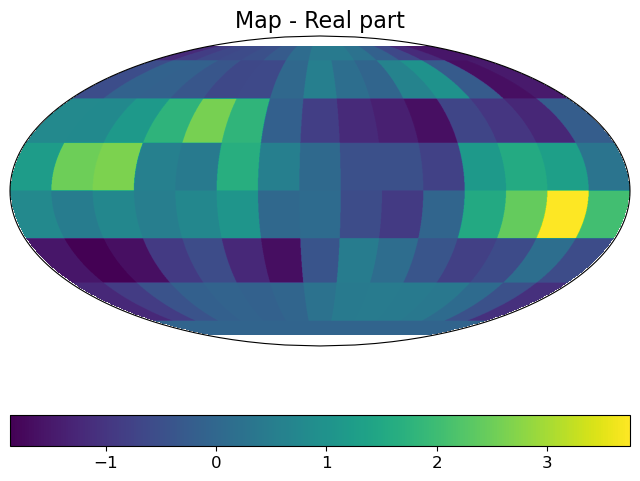

In [4]:
# Plot the map
mx, mn = np.nanmax(f_target), np.nanmin(f_target)
plot.plot_map_MW_Mollweide(f_target, figsize=(8, 6), vmin=mn, vmax=mx)

# Wavelets

In [5]:
filters = filters_directional_vectorised(L, N, J_min)[0]
print(filters.shape)

# plot.plot_filters(filters, real=True, m=L-1)

(4, 8, 15)


# Compute the coeff of the target

In [ ]:
# weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)
# precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False, reality, multiresolution)
reload(scatlib)
if axi:
    tmean, tvar, tS1, tP00, tC01, tC11 = scatlib.scat_cov_axi(flm_target, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters)
else:
    tmean, tvar, tS1, tP00, tC01, tC11 = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters,
                                                              quads=None, precomps=None)
print(tmean, tC01)

quad done
precomps done
W start
W done
Mlm done
starting Njj
Mlm done
starting Njj
Mlm done
starting Njj
Mlm done
starting Njj
starting C01, C11
0
C01 ok
C11 ok
1
C01 ok
C11 ok
2
C01 ok
C11 ok


# Initial condition

In [ ]:
f = np.random.randn(L, 2*L-1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)
flm = flm[:,L-1:] if reality else flm

flm_start = jnp.copy(flm)

# Define the loss

In [ ]:
@jit
def loss_func(flm):
    if axi:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_axi(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    else:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_dir(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)
    
    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)
    
    return loss


# Run the synthesis

In [ ]:
# Naive implementation
flm, loss_history = synlib.fit_brutal(flm, loss_func, momentum=2., niter=10)

In [ ]:
# Using Optax
# optimizer = optax.adagrad(learning_rate=1.)
optimizer = optax.sgd(learning_rate=1.)
flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func, niter=12)

# Check the synthesis

In [ ]:
reload(sphlib)
if reality:
    flm_full_target = sphlib.make_flm_full(flm_target, L)
    flm_full_start = sphlib.make_flm_full(flm_start, L)
    flm_full_end = sphlib.make_flm_full(flm, L)
else:
    flm_full_target = flm_target
    flm_full_start = flm_start
    flm_full_end = flm

f_target = s2fft.inverse_jax(flm_full_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_full_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_full_end, L, reality=reality)

### Plot the loss

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

In [ ]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(f_target, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

In [ ]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title='Target')

In [ ]:

plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='Output', central_longitude=0)

### Power spectrum

In [ ]:
reload(sphlib)
ps_target = sphlib.compute_ps(flm_full_target)
ps_start = sphlib.compute_ps(flm_full_start)
ps_end = sphlib.compute_ps(flm_full_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="target")
plt.plot(ps_start, 'g', label="start")
plt.plot(ps_end, 'r', label="end")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.legend()

### Plot the coefficients

In [ ]:
tmean, tvar, tS1, tP00, tC01, tC11 = scat_cov_axi(flm_full_target, L, N, J_min, sampling, None,
                                                  reality=False,
                                                  multiresolution=multiresolution,
                                                  filters=filters)
smean, svar, sS1, sP00, sC01, sC11 = scat_cov_axi(flm_full_start, L, N, J_min, sampling, None,
                                                  reality=False,
                                                  multiresolution=multiresolution,
                                                  filters=filters)
emean, evar, eS1, eP00, eC01, eC11 = scat_cov_axi(flm_full_end, L, N, J_min, sampling, None,
                                                  reality=False,
                                                  multiresolution=multiresolution,
                                                  filters=filters)

In [ ]:
reload(plot)
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue', lw=1)

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green', lw=1)

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red', lw=1)